In [ ]:
"""from google.colab import drive
drive.mount('/content/drive')

# Now you can access your Drive files using the path '/content/drive/My Drive/'
# For example, to access the "ODML" folder:
import os
odml_folder = '/content/drive/My Drive/ODML'

if os.path.exists(odml_folder):
  print(f"Successfully connected to '{odml_folder}'")
else:
  print(f"Could not find '{odml_folder}'")


# Change directory to the ODML folder
os.chdir(odml_folder)
!pip install torchprofile"""

In [1]:
import time
import os
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import pandas as pd
from torch import nn
from torch import optim
from torch.nn import functional as F
import torch.utils.data as data

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import torchprofile

In [2]:
train_dir = "data/sign_mnist_train.csv"
test_dir = "data/sign_mnist_test.csv"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
import torch
from torch.utils import data

class SignLanguageDataset(data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        label = self.df.iloc[index, 0]
        img = self.df.iloc[index, 1:].values.astype('uint8').reshape(28, 28)
        
        if self.transform is not None:
            img = self.transform(img)
        else:
            img = torch.from_numpy(img).unsqueeze(0).float()
        
        return img, label


In [5]:
# Normalizing the data and transforming it to tensor
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Lambda(lambda img: img.convert('RGB')),  # Convert grayscale to RGB
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the data
train_df = pd.read_csv(train_dir)
test_df = pd.read_csv(test_dir)

# Split the data into train and eval
ratio = 0.8
train_df, eval_df = train_df[:int(ratio*len(train_df))], train_df[int(ratio*len(train_df)):]

# Print all labels
print(sorted(train_df['label'].unique()), len(train_df['label'].unique()))
print(sorted(eval_df['label'].unique()), len(eval_df['label'].unique()))

train_dataset = SignLanguageDataset(train_df, transform=transform)
eval_dataset = SignLanguageDataset(eval_df, transform=transform)
test_dataset = SignLanguageDataset(test_df, transform=transform)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24] 24
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24] 24


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


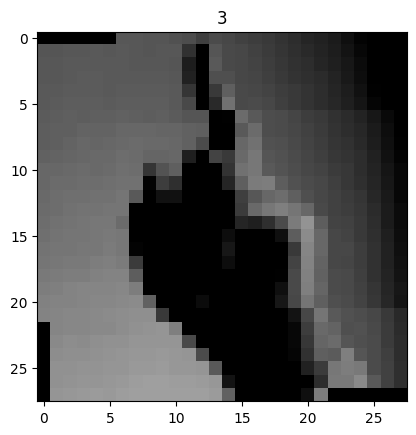

In [6]:
def show_img(img, label):
    plt.imshow(img.squeeze().permute(1, 2, 0))
    plt.title(label)
    plt.show()

show_img(*train_dataset[0])

In [6]:
# Use a pretrained ResNet model
model = models.resnet50(pretrained=True)

frozen = False
if frozen:
    for param in model.parameters():
        param.requires_grad = False

# Add a new layer to the model
last_layer_dim = model.fc.in_features
model.fc = nn.Linear(last_layer_dim, 26) # 26 classes (well excluding J and Z)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the data loaders
train_loader = data.DataLoader(train_dataset, batch_size=256, shuffle=True)
eval_loader = data.DataLoader(eval_dataset, batch_size=256, shuffle=False)
test_loader = data.DataLoader(test_dataset, batch_size=256, shuffle=False)

e:\anaconda3\envs\p3-env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\anaconda3\envs\p3-env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for img, label in tqdm(train_loader, desc="Training"):
        img, label = img.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(output, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

    avg_loss = train_loss / len(train_loader)
    accuracy = correct / total
    return avg_loss, accuracy

def evaluate(model, eval_loader, criterion, device):
    model.eval()
    eval_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for img, label in tqdm(eval_loader, desc="Evaluating"):
            img, label = img.to(device), label.to(device)
            output = model(img)
            loss = criterion(output, label)
            eval_loss += loss.item()
            _, predicted = torch.max(output, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()

    avg_loss = eval_loss / len(eval_loader)
    accuracy = correct / total
    return avg_loss, accuracy

def test(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for img, label in tqdm(test_loader, desc="Testing"):
            img, label = img.to(device), label.to(device)
            output = model(img)
            loss = criterion(output, label)
            test_loss += loss.item()
            _, predicted = torch.max(output, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()

    avg_loss = test_loss / len(test_loader)
    accuracy = correct / total
    return avg_loss, accuracy

In [8]:
# Training loop
n_epochs = 5 if str(device) == 'cuda' else 2
train_losses = []
eval_losses = []
train_acc = []
eval_acc = []

model.to(device)

for epoch in range(n_epochs):
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion, device)
    eval_loss, eval_accuracy = evaluate(model, eval_loader, criterion, device)

    train_losses.append(train_loss)
    train_acc.append(train_accuracy)
    eval_losses.append(eval_loss)
    eval_acc.append(eval_accuracy)

    print(f"Epoch {epoch+1}/{n_epochs}")
    print(f"Train Loss: {train_loss:.3f} | Train Accuracy: {train_accuracy:.3f}")
    print(f"Eval Loss: {eval_loss:.3f} | Eval Accuracy: {eval_accuracy:.3f}")

test_loss, test_accuracy = test(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.3f} | Test Accuracy: {test_accuracy:.3f}")

Evaluating: 100%|██████████| 22/22 [00:02<00:00,  9.37it/s]


Epoch 1/2
Train Loss: 0.697 | Train Accuracy: 0.771
Eval Loss: 0.294 | Eval Accuracy: 0.901


Evaluating: 100%|██████████| 22/22 [00:02<00:00,  9.33it/s]

Epoch 2/2
Train Loss: 0.136 | Train Accuracy: 0.955
Eval Loss: 0.177 | Eval Accuracy: 0.943


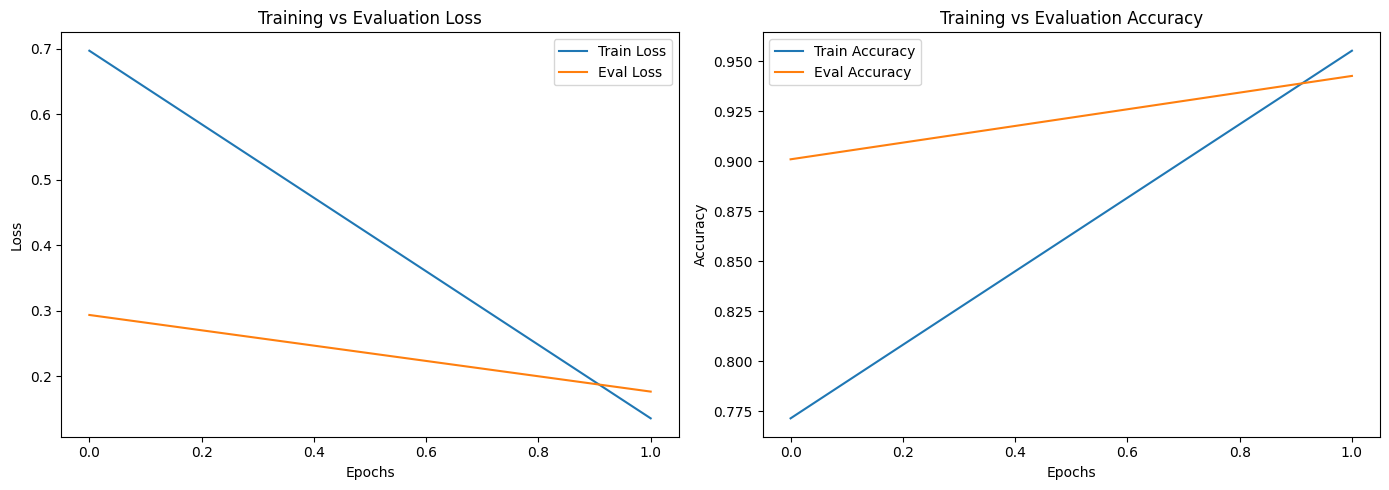

In [12]:
# Create a 1x2 subplot to display the loss and accuracy side by side
plt.figure(figsize=(14, 5))

# Plot the training and evaluation loss on the left
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(eval_losses, label='Eval Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Evaluation Loss')
plt.legend()

# Plot the training and evaluation accuracy on the right
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(eval_acc, label='Eval Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Evaluation Accuracy')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [16]:
def measure_inference_latency(model, data_loader, device):
    model.eval()
    total_time = 0.0
    warmup = True

    with torch.no_grad():
        for i, (img, label) in enumerate(data_loader):
            img = img.to(device)
            start_time = time.time()

            # Forward pass
            model(img)

            # Record time
            latency = time.time() - start_time

            # Skip the warmup run
            if warmup:
                warmup = False
                continue

            total_time += latency

    avg_latency = total_time / (len(data_loader) - 1)  # Exclude warmup
    return avg_latency

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def count_flops(model, data_loader, device):
    model.eval()
    img, _ = next(iter(data_loader))  # Get one batch
    img = img.to(device)

    # Profile FLOPs
    flops = torchprofile.profile_macs(model, img)
    return flops

In [17]:
# Calculate the number of parameters, FLOPs, and inference latency
n_params = count_parameters(model)
flops = count_flops(model, test_loader, device)
latency = measure_inference_latency(model, test_loader, device)

print(f"Number of Parameters: {n_params}")
print(f"Number of FLOPs: {flops}")
print(f"Average Inference Latency: {latency:.6f} seconds")

Number of Parameters: 11189850
Number of FLOPs: 8778743808
Average Inference Latency: 0.040522 seconds
